In [2]:

from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Data Preprocessing

In [3]:
path_to_data = Path('../data')

data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)
cards = [
    # Diamonds
    'DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6',
    # Hearts
    'HA', 'HK', 'HQ', 'HJ', 'H10', 'H9', 'H8', 'H7', 'H6',
    # Spades
    'SA', 'SK', 'SQ', 'SJ', 'S10', 'S9', 'S8', 'S7', 'S6',
    # Clubs
    'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7', 'C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user = ['user']
trump = ['trump']

feature_columns = cards + forehand

data.columns = cards + forehand + user + trump


### Remve entries with anonymous user

In [4]:
data.drop(data[data['user'] == 0].index, inplace=True)

### Load User Stats

In [5]:
player_stats = pd.read_json(path_to_data / 'stat' / 'player_all_stat.json')
player_stats.head()

,id,mean,std,nr
0,0,78.433100,42.186764,1978858
1,6955,76.191936,41.780344,4241
2,54404,78.010880,41.985297,7445
3,74994,76.775460,41.428476,7669
4,56143,76.774029,41.546253,978


In [6]:
print(f"Average mean: {player_stats['mean'].mean()}")

Average mean: 77.42586010810032


<Axes: >

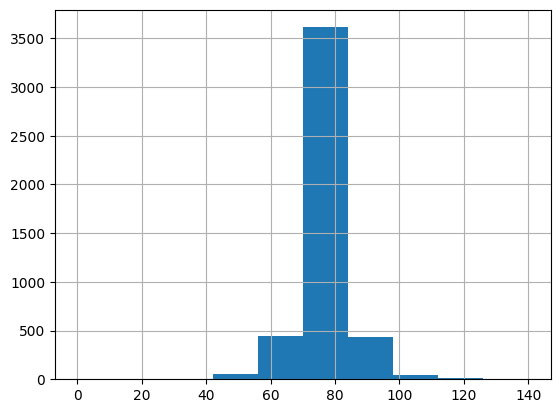

In [7]:
player_stats['mean'].hist()

### Add mean to trump dataset

In [8]:
data = data.merge(player_stats, left_on='user', right_on='id', how='left')
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,C8,C7,C6,FH,user,trump,id,mean,std,nr
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,53248,6,53248,80.209033,42.565519,4229
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,4613,5,4613,79.254714,42.536770,3553
2,1,0,0,1,0,0,0,0,0,0,...,0,1,1,0,68780,6,68780,78.182220,42.183286,2261
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,24555,5,24555,72.863905,41.739546,169
4,0,1,0,0,0,0,0,0,1,1,...,0,0,0,1,8392,4,8392,80.793806,42.461401,8104


In [9]:
player_stats['mean'].mean()

np.float64(77.42586010810032)

### Delete entries from users that are below average

In [10]:
data = data[data['mean'] > player_stats['mean'].mean()]

### Drop unneeded variables

In [11]:
data.drop('user', axis='columns', inplace=True)
data.drop('mean', axis='columns', inplace=True)
data.drop(columns=['id'], inplace=True)
data.drop(columns=['std'], inplace=True)
data.drop(columns=['nr'], inplace=True)

data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,6
1,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,5
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,6
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,4
5,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,5


### One-Hot-Encode Trump

In [12]:
data.trump = data.trump.astype('category')
data.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3: 'CLUBS',
                                               4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})

data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,PUSH
1,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,UNE_UFE
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,PUSH
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,OBE_ABE
5,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,UNE_UFE


## Model

In [13]:
X = data[feature_columns]
y = data[
    [
        "trump_DIAMONDS",
        "trump_HEARTS",
        "trump_SPADES",
        "trump_CLUBS",
        "trump_OBE_ABE",
        "trump_UNE_UFE",
        "trump_PUSH",
    ]
]

KeyError: "None of [Index(['trump_DIAMONDS', 'trump_HEARTS', 'trump_SPADES', 'trump_CLUBS',\n       'trump_OBE_ABE', 'trump_UNE_UFE', 'trump_PUSH'],\n      dtype='object')] are in the [columns]"

Split into training and testing sets. Normalization is not necessary, because everything in the dataset is one-hot-encoded

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CA,CK,CQ,CJ,C10,C9,C8,C7,C6,FH
63633,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
49412,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
96190,0,0,0,0,0,1,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
146023,0,0,1,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
233123,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184839,0,1,1,0,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
160108,0,0,1,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
202966,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
225604,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(592, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(Dense(592, activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)))
model.add(keras.layers.Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20


C:\workspace\hslu\dl4g\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6923/6923 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6206 - loss: 1.0236 - val_accuracy: 0.6395 - val_loss: 0.9027
Epoch 2/20
6923/6923 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6424 - loss: 0.9112 - val_accuracy: 0.6543 - val_loss: 0.8653
Epoch 3/20
6923/6923 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6474 - loss: 0.8900 - val_accuracy: 0.6544 - val_loss: 0.8527
Epoch 4/20
6923/6923 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6500 - loss: 0.8785 - val_accuracy: 0.6598 - val_loss: 0.8523
Epoch 5/20
6923/6923 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6519 - loss: 0.8725 - val_accuracy: 0.6635 - val_loss: 0.8434
Epoch 6/20
6923/6923 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6516 - loss: 0.8672 - val_accuracy: 0.6612 - val_loss: 0.8419
Epoch 7/20
6923/6923 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6541 - loss: 0.8657 - val_accuracy: 0.6623 - val_loss: 0.8360
Epoch 8/20
6923/6923 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6545 - loss: 0.8644 - val

In [28]:
model.save('trump_model.keras')

In [29]:
# Predict on new data
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=1)  # Convert softmax output to class label
predicted_classes

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step


array([6, 4, 5, ..., 5, 2, 6], shape=(34615,))